In [ ]:
from __future__ import print_function, division
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2


## Helper Function

In [18]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles, reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)


In [19]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y


In [20]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='C:/Users/sneha/Desktop/SketchToImage/SketchToImage/Models', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')
    
    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')
    
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))


## Generator

In [21]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d
    
    # Input Layer
    in_img = Input(shape=img_shape)
    
    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)
    
    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)
    
    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(in_img, out_img, name='generator')


## Discriminator

In [22]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    merged = Concatenate()([in_src_img, in_target_img])
    
    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model([in_src_img, in_target_img], out, name='discriminator')


## GAN

In [23]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model


## Train GAN model

In [24]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=5, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    blue_photo = data[0]
    blue_sketch = data[1]
    
    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')
        
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))
            
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            d_loss = 0.5 * np.add(d_loss1, d_loss2)
            
            # Print shapes for debugging
            #print("Shapes before GAN training:")
            #print("X_realA shape:", X_realA.shape)
            #print("y_real shape:", y_real.shape)
            #print("X_realB shape:", X_realB.shape)
            
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            
            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
        
        # summarize model performance
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, target_dir)


## Loss Function

In [25]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss(y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)
    
    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
    
    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1, p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1, p_shape[1]]))
    
    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)


def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)
    
    return (0.2 * px_loss) + (0.8 * ctx_loss)


## Load Dataset

In [10]:
# dataset path
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

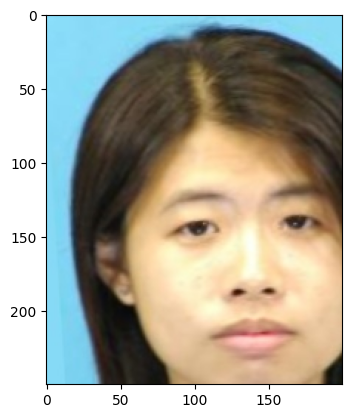

In [11]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

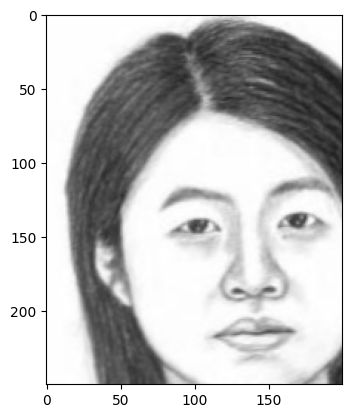

In [26]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

## Define GAN Model

In [27]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)


In [28]:
gan_model.summary()


Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 256, 3)          4182569   ['input_8[0][0]']             
                                                          1                                       
                                                                                                  
 discriminator (Functional)  (None, 64, 64, 1)            539203    ['input_8[0][0]',             
                                                                     'generator[0][0]']           
                                                                                                

In [29]:
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

# Recompile GAN model after updating discriminator and generator
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])


## Start Training

In [30]:
# Save the trained models
save_model(d_model, target_directory, "discriminator_model.h5")
save_model(g_model, target_directory, "generator_model.h5")
save_model(gan_model, target_directory, "gan_model.h5")
target_directory = "C:/Users/sneha/Desktop/SketchToImage/SketchToImage/Models"
def save_model(model, target_dir, model_name):
    model.save(os.path.join(target_dir, model_name))
    print(f"Saved {model_name} to {target_dir}")


NameError: name 'save_model' is not defined

In [ ]:




train(d_model, g_model, gan_model, [blue_sketch, blue_photo], 'Models/Pixel[02]_Context[08]/', n_epochs=5, n_batch=16)


In [ ]:
# Assuming you have defined your models (d_model, g_model, gan_model) and loaded your data
target_directory = "C:/Users/Asus/Desktop/Python_Projects/SketchToImage/Models"
train_and_save_models(d_model, g_model, gan_model, data, target_directory, n_epochs=10, n_batch=16)


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [19]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

0
